In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Behavior and personality prediction using HCP movie-watching data

In [36]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import numpy as np
import pandas as pd
import pickle
import os
from cc_utils import _get_clip_labels
from gru.rb_utils import (
    _get_results, get_cv_tbest, cv_agg,
    get_grid_acc, get_best_param,
    get_test_tbest, get_test_predictions,
    get_static, get_static_predictions)

# stats 
from scipy.stats import spearmanr

# plot
from matplotlib import pyplot
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = 'plotly_white'
from plot_utils import (
    _hex_to_rgb, _plot_ts,
    _add_box, _highlight_max)

colors = px.colors.qualitative.Plotly
ccc = {'Train': '#D55E00', 
    'Validation': '#CC79A7',
    'Test': '#CC79A7'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Important parameters for visualization

In [3]:
""" score: accuracy measure
    
    options:
        's': Spearman rank correlation
        'p': Pearson correlation
        'mse': mean-squared error
"""
score = 's'
pretty_score = 'Spearman rank correlation'

""" criteria for hyperparameter selection
    note: predictions are made for each clip
    
    options:
        'max': based on 'max/min' score across clips
        'mean': based on 'mean' score across clips
"""
criteria = 'mean'

## Model parameters and clip information

In [4]:
roi = 300
net = 7
subnet = 'wb'

zscore = 1
k_fold = 5
train_size = 100

In [5]:
clip_y = _get_clip_labels()
clip_y['testretest'] = 0
k_clip = len(np.unique(list(clip_y.values())))

clip_names = np.zeros(k_clip).astype(str)
clip_names[0] = 'testretest'
for key, item in clip_y.items():
    if item != 0:
        clip_names[item] = key
        
select_bhv = ['PMAT24_A_CR', 'PicVocab_Unadj',
              'NEOFAC_A', 'NEOFAC_E', 'NEOFAC_C',
              'NEOFAC_N', 'NEOFAC_O']

pretty_bhv = {}
for bhv in select_bhv:
    pretty_bhv[bhv] = bhv
pretty_bhv['PMAT24_A_CR'] = 'Fluid Intelligence'
pretty_bhv['PicVocab_Unadj'] = 'Verbal IQ'
print('Behavior / personality scores include:')
for bhv in select_bhv:
    print(pretty_bhv[bhv])

Behavior / personality scores include:
Fluid Intelligence
Verbal IQ
NEOFAC_A
NEOFAC_E
NEOFAC_C
NEOFAC_N
NEOFAC_O


In [6]:
class GRU_ARGS():
    roi = roi
    net = net
    subnet = subnet
    
    zscore = zscore
    k_fold = k_fold
    train_size = train_size
    
    # model
    model_type = 'gru'
    k_param = [32]
    param_str = 'k_hidden'
    k_layers = 1
    batch_size = 30
    num_epochs = [20]
    
    l2 = 0.0
    dropout=0.000001
    lr=0.001
    
    RES_DIR = 'results/bhv_{}'.format(model_type)
    
    select_bhv = select_bhv
    clip_names = clip_names
    clip_y = clip_y

In [7]:
class FF_ARGS():
    roi = roi
    net = net
    subnet = subnet
    
    zscore = zscore
    k_fold = k_fold
    train_size = train_size
    
    # model
    model_type = 'ff'
    k_param = [1]
    param_str = 'k_layers'
    k_hidden = 103
    batch_size = 30
    num_epochs = [20]
    
    RES_DIR = 'results/bhv_{}'.format(model_type)
    
    select_bhv = select_bhv
    clip_names = clip_names
    clip_y = clip_y

In [8]:
class TCN_ARGS():
    roi = roi
    net = net
    subnet = subnet
    
    zscore = zscore
    k_fold = k_fold
    train_size = train_size
    
    # model
    model_type = 'tcn'
    k_param = [5]
    param_str = 'k_wind'
    k_hidden = 25
    batch_size = 30
    num_epochs = [20]
    
    RES_DIR = 'results/bhv_{}'.format(model_type)
    
    select_bhv = select_bhv
    clip_names = clip_names
    clip_y = clip_y

In [9]:
class CPM_ARGS():
    roi = roi
    net = net
    subnet = subnet
    
    zscore = zscore
    k_fold = k_fold
    train_size = train_size
    
    # cpm
    model_type = 'cpm'
    k_param = [0.2]
    param_str = 'corr_thresh'
    
    RES_DIR = 'results/bhv_{}'.format(model_type)
    
    select_bhv = select_bhv
    clip_names = clip_names
    clip_y = clip_y

In [10]:
models = ['gru','ff','tcn','cpm']
pretty_model = {'gru': 'Gated Recurrent Unit',
                'ff': 'Feedforward Neural Network',
                'tcn': 'Temporal Convolutional Network',
                'cpm': 'Connectome-based Predictive Modeling'}
print('Models include:')
for model in models:
    print(f'{model.upper():5}: {pretty_model[model]}')

Models include:
GRU  : Gated Recurrent Unit
FF   : Feedforward Neural Network
TCN  : Temporal Convolutional Network
CPM  : Connectome-based Predictive Modeling


In [11]:
args = {}
args['gru'] = GRU_ARGS()
args['ff'] = FF_ARGS()
args['tcn'] = TCN_ARGS()
args['cpm'] = CPM_ARGS()

K_RUNS = 4

## Find best hyperparameters for behavior prediction

In [12]:
opt_hyperparam = {}
for model in models:
    opt_hyperparam[model] = {}
    for ii, bhv in enumerate(select_bhv):
        opt_hyperparam[model][bhv] = {}
        if model in ['gru','ff','tcn']:
            num_epoch, k_param = get_best_param(
                args[model], bhv, score = score, criteria = criteria)
            print('{:4} - {:20}: num_epochs = {:02}, {:10} = {}'.format(
                model, pretty_bhv[bhv], num_epoch, 
                args[model].param_str, k_param))
            opt_hyperparam[model][bhv]['num_epochs'] = num_epoch
            opt_hyperparam[model][bhv][args[model].param_str] = k_param
        elif model in ['cpm', 'bbs']:
            k_param = get_best_param(
                args[model], bhv, score = score, criteria = criteria)
            print('{:4} - {:20}: {} = {}'.format(
                model, bhv, args[model].param_str, k_param))
            opt_hyperparam[model][bhv][args[model].param_str] = k_param
    print('---')

32 20
gru  - Fluid Intelligence  : num_epochs = 20, k_hidden   = 32
32 20
gru  - Verbal IQ           : num_epochs = 20, k_hidden   = 32
32 20
gru  - NEOFAC_A            : num_epochs = 20, k_hidden   = 32
32 20
gru  - NEOFAC_E            : num_epochs = 20, k_hidden   = 32
32 20
gru  - NEOFAC_C            : num_epochs = 20, k_hidden   = 32
32 20
gru  - NEOFAC_N            : num_epochs = 20, k_hidden   = 32
32 20
gru  - NEOFAC_O            : num_epochs = 20, k_hidden   = 32
---
1 20
ff   - Fluid Intelligence  : num_epochs = 20, k_layers   = 1
1 20
ff   - Verbal IQ           : num_epochs = 20, k_layers   = 1
1 20
ff   - NEOFAC_A            : num_epochs = 20, k_layers   = 1
1 20
ff   - NEOFAC_E            : num_epochs = 20, k_layers   = 1
1 20
ff   - NEOFAC_C            : num_epochs = 20, k_layers   = 1
1 20
ff   - NEOFAC_N            : num_epochs = 20, k_layers   = 1
1 20
ff   - NEOFAC_O            : num_epochs = 20, k_layers   = 1
---
5 20
tcn  - Fluid Intelligence  : num_epochs = 20, k_w

## Get test score and prediction based on optimal hyperparameters

In [24]:
def get_score_and_predictions(args, star_hyper, score):
    """get test accuracy and predictions at tbest
        
    Args:
        bhv_measures
        star_hyper: saved optimal hyperparameters
        score: 'p', 's', or 'mse'
        
    Return:
        test_acc: best score
        y_hat: predictions
        y: true scores
    """
    bhv_measures = args.select_bhv
    k_clips = len(clip_names)
    
    test_acc = {}
    clip_test_acc = {}
    y_hat, y = {}, {}
    fig = {}
    for ii, bhv in enumerate(bhv_measures):
        
        if args.model_type in ['gru','ff','tcn']:
            num_epochs = star_hyper[bhv]['num_epochs']
            k_param = star_hyper[bhv][args.param_str]
            r = _get_results(args, bhv, num_epochs, k_param)
            
            clip_test_acc[bhv] = np.zeros(len(clip_names))
            for jj, clip in enumerate(clip_names):
                _, V = get_test_tbest(args, clip, r, score)
                clip_test_acc[bhv][jj] = V

            if score != 'mse':
                best_clip = clip_names[np.argmax(clip_test_acc[bhv])]
                test_acc[bhv] = np.max(clip_test_acc[bhv])
            else:
                best_clip = clip_names[np.argmin(clip_test_acc[bhv])]
                test_acc[bhv] = np.min(clip_test_acc[bhv])

            y_hat[bhv], y[bhv] = get_test_predictions(args, best_clip, 
                                                      r, score)
            
        elif args.model_type in ['cpm', 'bbs']:
            k_param = star_hyper[bhv][args.param_str]
            r = _get_results(args, bhv, k_param = k_param)

            c_acc = np.zeros(k_clips)
            for jj, clip in enumerate(clip_names):
                _, V = get_static(args, clip, r, score)
                c_acc[jj] = V

            if score != 'mse':
                best_clip = clip_names[np.argmax(c_acc)]
            else:
                best_clip = clip_names[np.argmin(c_acc)]

            _, test_acc[bhv] = get_static(args, best_clip, r, score,
                                          mode='test')

            y_hat[bhv], y[bhv] = get_static_predictions(args, best_clip, 
                                                        r, score)
        
        # df for px
        df = pd.DataFrame({'true': y[bhv],
                           'predicted':y_hat[bhv]})
        fig[bhv] = px.scatter(df, x='true', 
            y='predicted', trendline='ols')
        fig[bhv].update_layout(height=350, width=400,
                               title_text=pretty_bhv[bhv])
        fig[bhv].update_xaxes(dtick=0.2)
        fig[bhv].update_yaxes(dtick=0.2)
    
    return test_acc, y_hat, y, fig, clip_test_acc

In [25]:
test_acc = {}
save_y_hat, save_y = {}, {}

for model in models:
    if model == 'gru':
        t_acc, pred, true, _, clip_t_acc = get_score_and_predictions(
            args[model], opt_hyperparam[model], score)
    else:
        t_acc, pred, true, _, _ = get_score_and_predictions(
        args[model], opt_hyperparam[model], score)
    test_acc[model] = t_acc
    save_y_hat[model] = pred
    save_y[model] = true

In [26]:
best_score = {'bhv':[]}
for model in models:
    best_score[model.upper()] = []
for ii, bhv in enumerate(select_bhv):
    best_score['bhv'].append(pretty_bhv[bhv])
    for model in models:
        best_score[model.upper()].append(f'{test_acc[model][bhv]:.4f}')
df = pd.DataFrame(best_score)
df

,bhv,GRU,FF,TCN,CPM
0,Fluid Intelligence,0.3442,0.2231,0.2816,0.0655
1,Verbal IQ,0.2579,0.1738,0.2563,-0.0193
2,NEOFAC_A,0.1502,0.2503,0.1495,-0.0143
3,NEOFAC_E,0.2452,0.3578,0.3153,0.0899
4,NEOFAC_C,0.2552,0.2635,0.3065,0.1006
5,NEOFAC_N,0.1572,0.1205,0.2033,0.0633
6,NEOFAC_O,0.1910,0.1990,0.3204,0.1623


In [28]:
fig = go.Figure()
for model in models:
    y = []
    x = []
    for bhv in select_bhv:
        x.append(pretty_bhv[bhv])
        y.append(test_acc[model][bhv])
    bar = go.Bar(name = model.upper(),
                 x = x, y = y)
    fig.add_trace(bar)
    
fig.update_layout(barmode = 'group')
fig.update_xaxes(title_text = 'Model')
fig.update_yaxes(title_text = pretty_score)
fig.show()

In [29]:
fig = go.Figure()
for bhv in select_bhv:
    y = []
    x = []
    for model in models:
        x.append(model.upper())
        y.append(test_acc[model][bhv])
    bar = go.Bar(name = pretty_bhv[bhv],
                 x = x, y = y)
    fig.add_trace(bar)
    
fig.update_layout(barmode = 'group')
fig.update_xaxes(title_text = 'Behavior/Personality score')
fig.update_yaxes(title_text = pretty_score)
fig.show()

In [30]:
for bhv in select_bhv:
    plot_y, plot_y_hat = [], []
    plot_tag = []
    #for model in models:
    for model in ["gru","cpm"]:
        plot_y += list(save_y[model][bhv])
        plot_y_hat += list(save_y_hat[model][bhv])
        k_sub = len(save_y[model][bhv])
        plot_tag += [model]*k_sub

    # df for px
    df = pd.DataFrame(
        {'true': plot_y, 'predicted': plot_y_hat,
         'tag': plot_tag})
    fig = px.scatter(df, x='true', y='predicted', 
                     color='tag', trendline='ols')
    fig.update_layout(height=400, width=480,
                      title_text=pretty_bhv[bhv],
                      font_color='black',
                      legend_font_size=20)
    fig.update_xaxes(dtick=0.2, tickfont=dict(size=20),
                     title=dict(text='True',
                                font_size=20))
    fig.update_yaxes(dtick=0.2, tickfont=dict(size=20),
                     title=dict(text='Predicted',
                                font_size=20))
    fig.show()

In [31]:
heatmap = pd.DataFrame(clip_t_acc,index=clip_names)
heatmap.rename(columns=pretty_bhv,inplace=True)
heatmap = heatmap.T

fig = px.imshow(heatmap.values,x=heatmap.columns,
                y=heatmap.index,
                color_continuous_scale='YlOrRd',
                zmin=0.,zmax=1.0, aspect=1,
                width=1000)

fig.update_xaxes(side="bottom",tickfont_size=16)
fig.update_yaxes(tickfont_size=16)
fig.show()

In [40]:
def violin_slope_chart(A_list, B_list):
    """
    A_list and B_list contain:
    [fold accuracy values, label, color]
    """
    red = '#C25539'
    blue = '#3F7F93'
    global xlim_left
    global xlim_right
    if len(A_list) == 2:
        A_list += [None]
        B_list += [None]
    A, A_label, A_color = A_list
    B, B_label, B_color = B_list
    fig = pyplot.figure(figsize=(6, 4), dpi=300)
    # create slope chart
    delta = 0.1
    A, B = np.array(A), np.array(B)
    # use red lines for increasing values
    for a, b in zip(A[A < B], B[A < B]):
        x, y = [-1 + delta, 1 - delta], [a, b]
        pyplot.plot(x, y, marker='o', c=red, alpha=0.25)
    # use blue lines for decreasing values
    for a, b in zip(A[A > B], B[A > B]):
        x, y = [-1 + delta, 1 - delta], [a, b]
        pyplot.plot(x, y, marker='o', c=blue, alpha=0.25)
    # violin plots
    violins = pyplot.violinplot([A, B], 
                             positions=[-1 - delta, 1 + delta],
                             widths=0.25,
                             showmeans=True, 
                             showmedians=True)
    for pc in violins['bodies']:
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
    p = sum([a>b for a,b in zip(A,B)])/len(A)
    p_string = "p({A_label} > {B_label}) = {p}".format(A_label=A_label,
                                                       B_label=B_label,
                                                       p=p)
    ymin = min(np.min(A), np.min(B))
    pyplot.text(x=0, 
                y=ymin, 
                s=p_string, 
                verticalalignment='bottom', 
                horizontalalignment='center')
    pyplot.xticks([-1, 1], [A_label, B_label])
    pyplot.ylabel('Accuracy')
    pyplot.show()
    # report p-value
    if not np.isscalar(B):
        print()

Fluid Intelligence


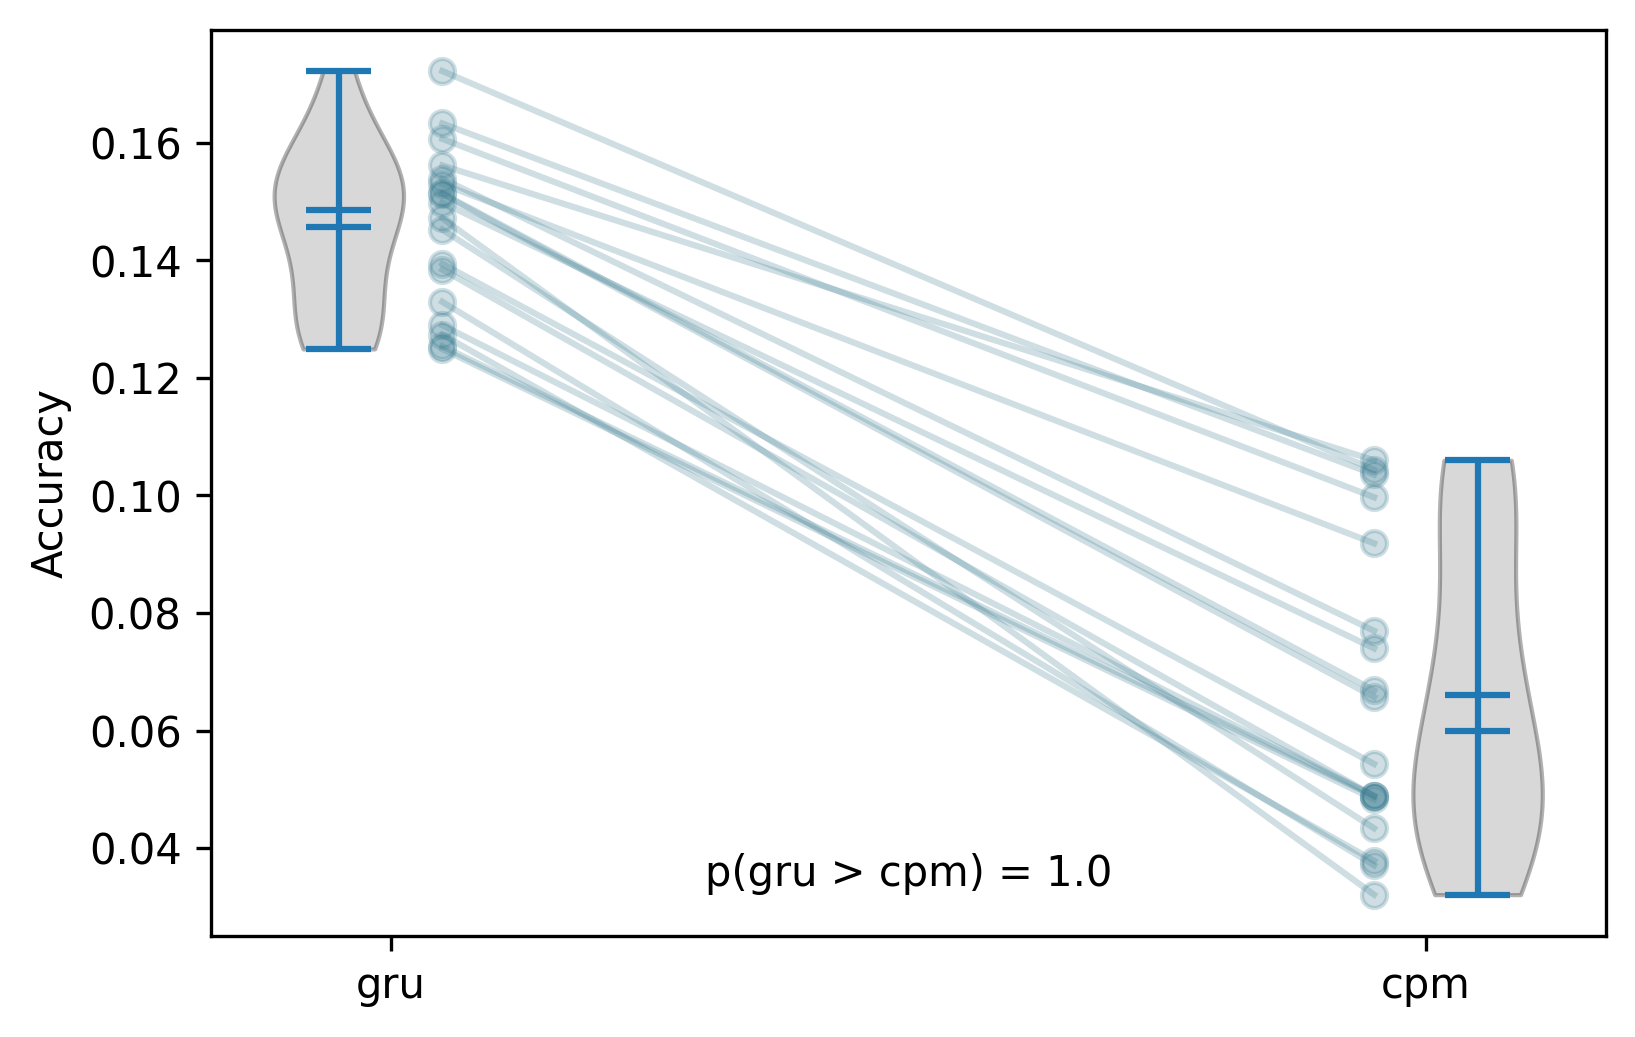


Verbal IQ


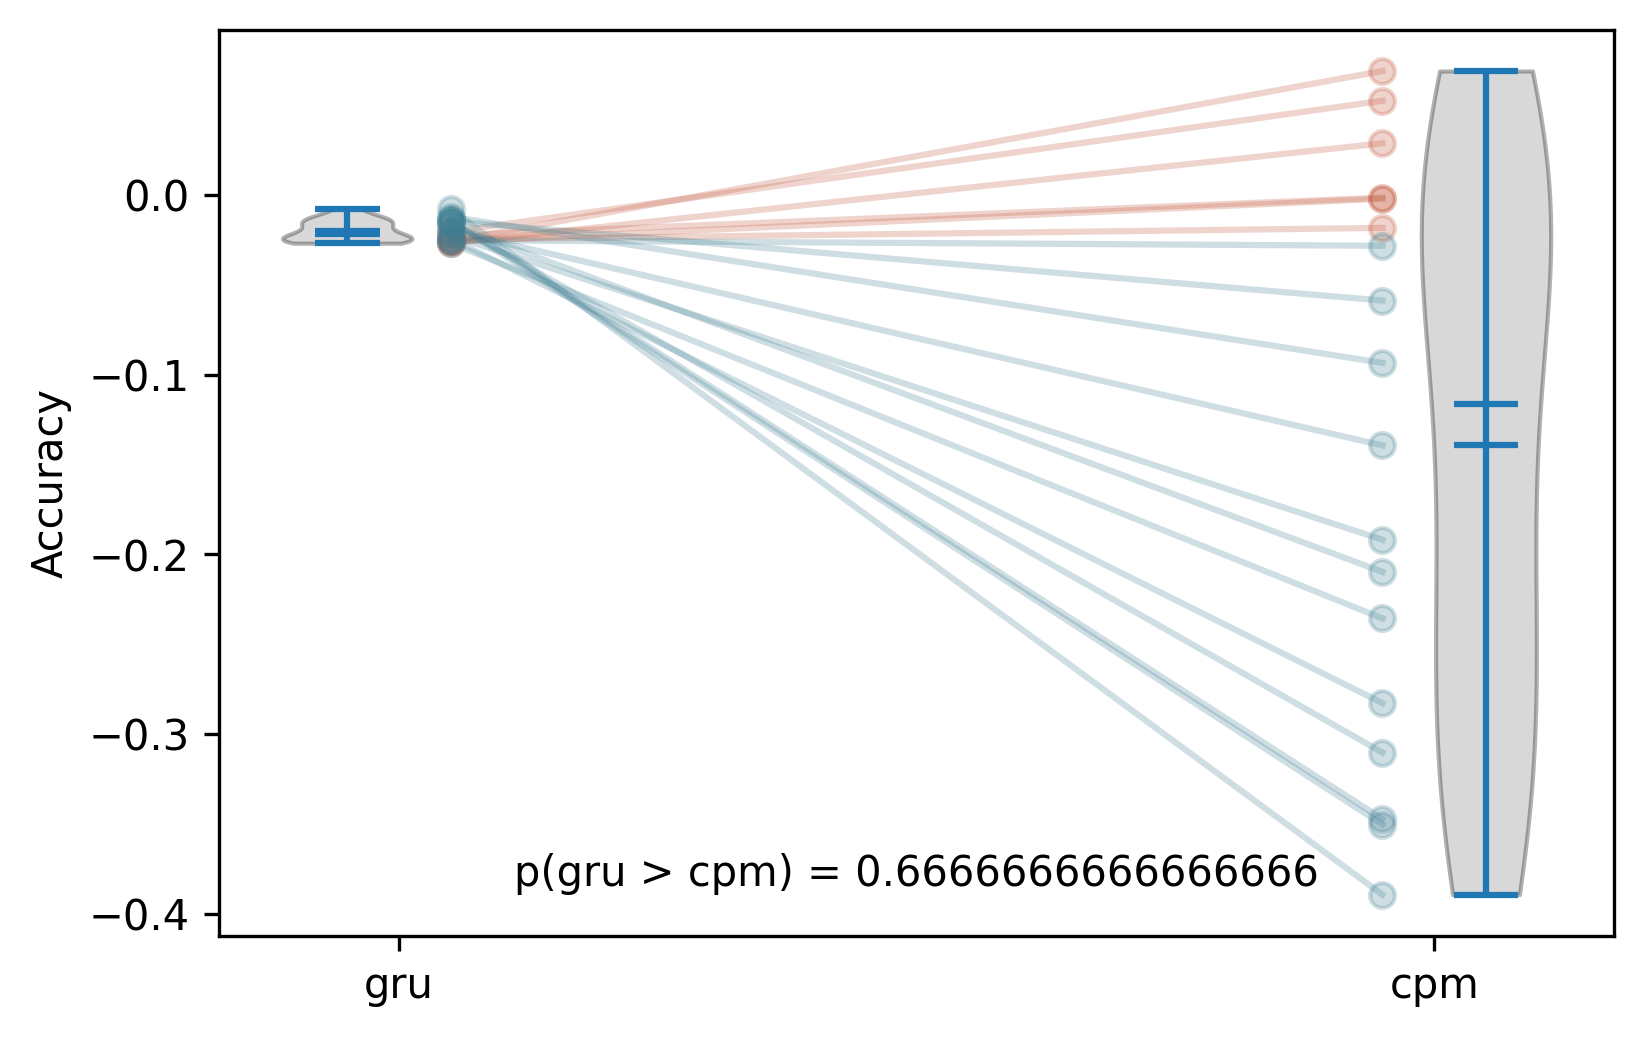


NEOFAC_A


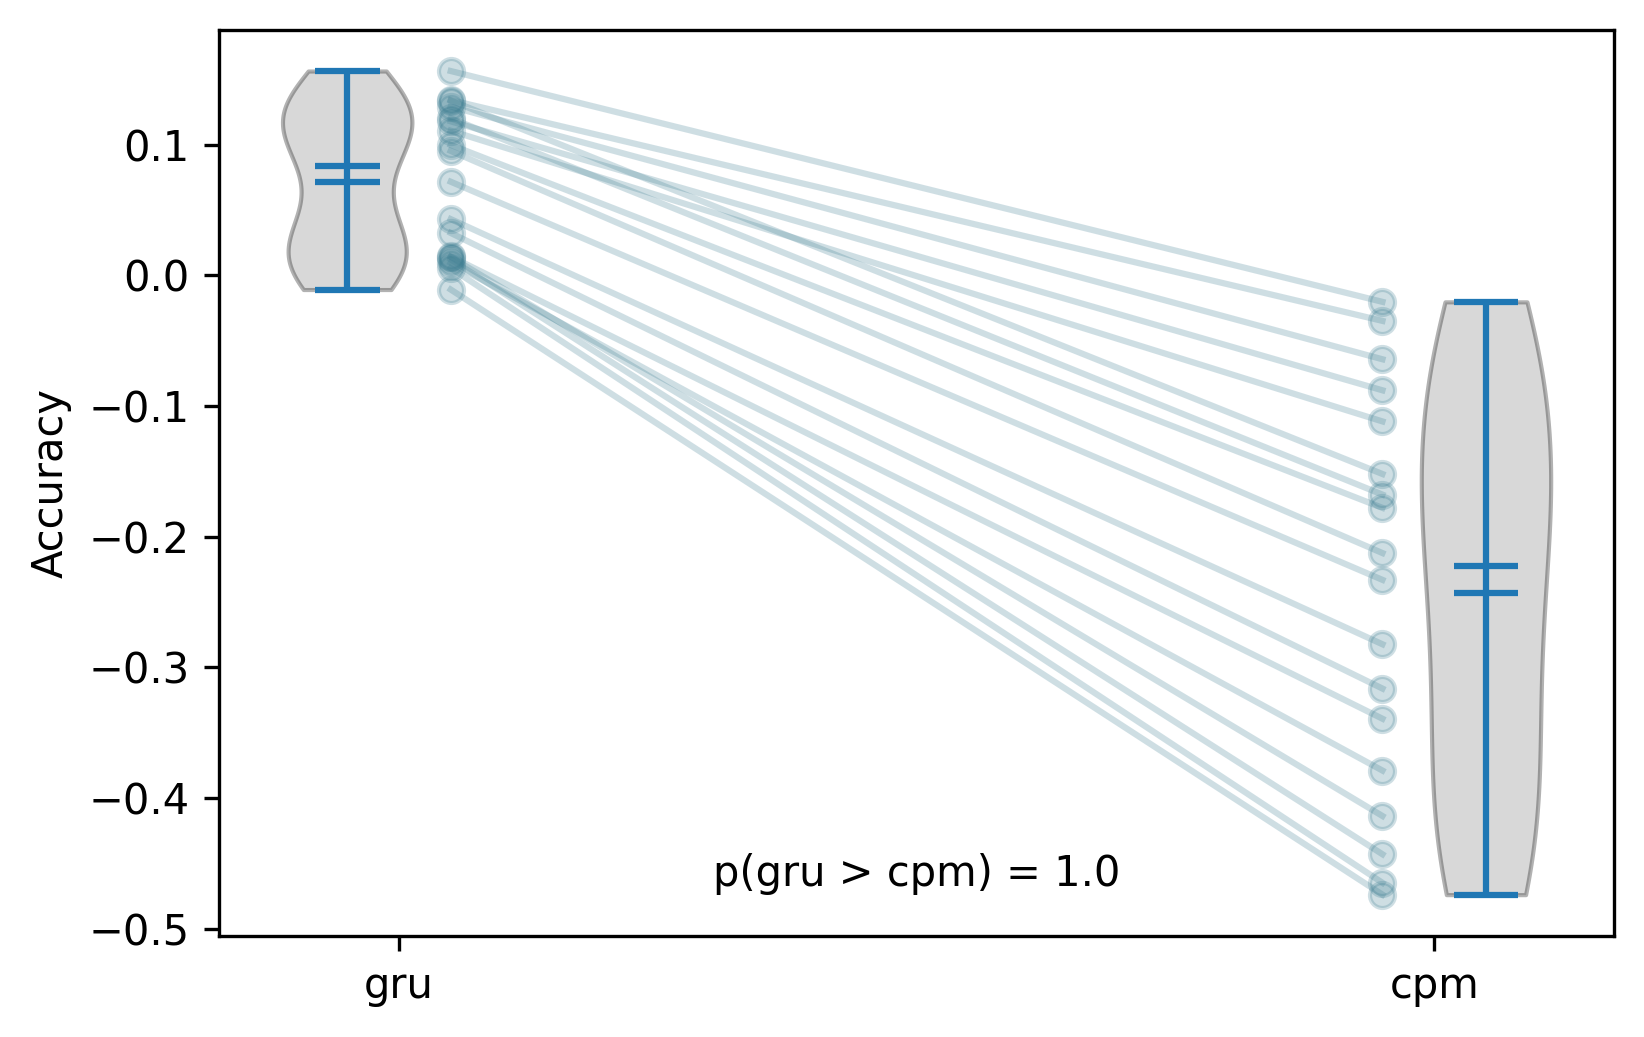


NEOFAC_E


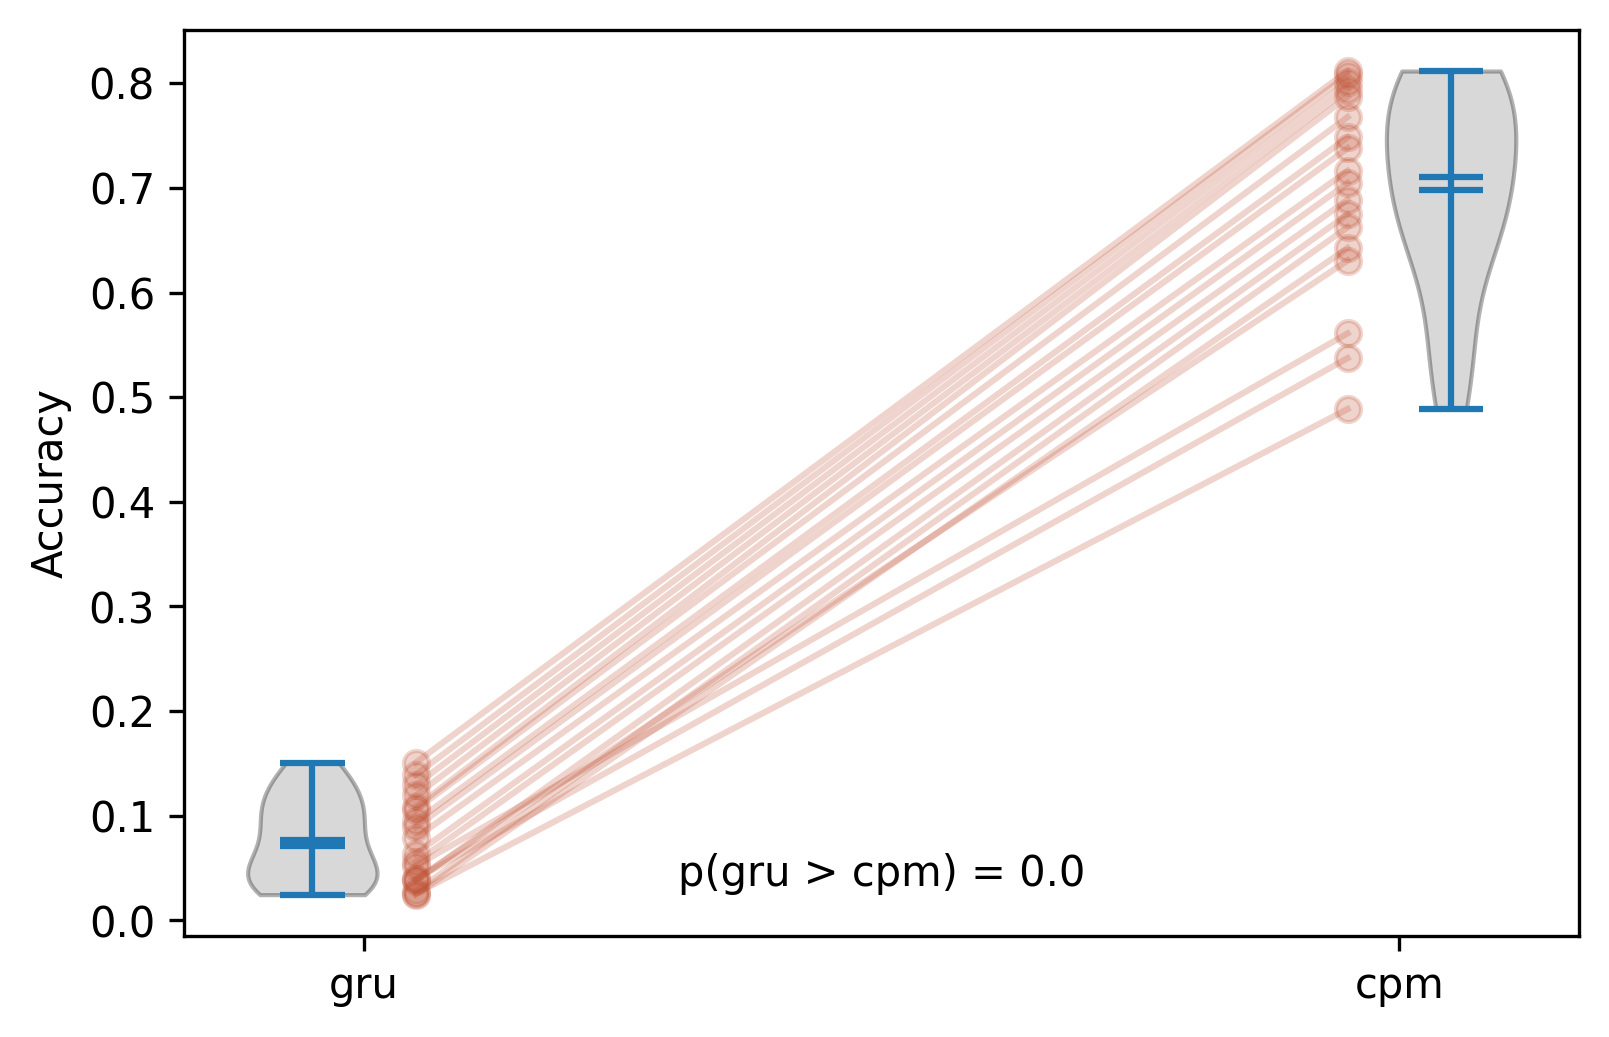


NEOFAC_C


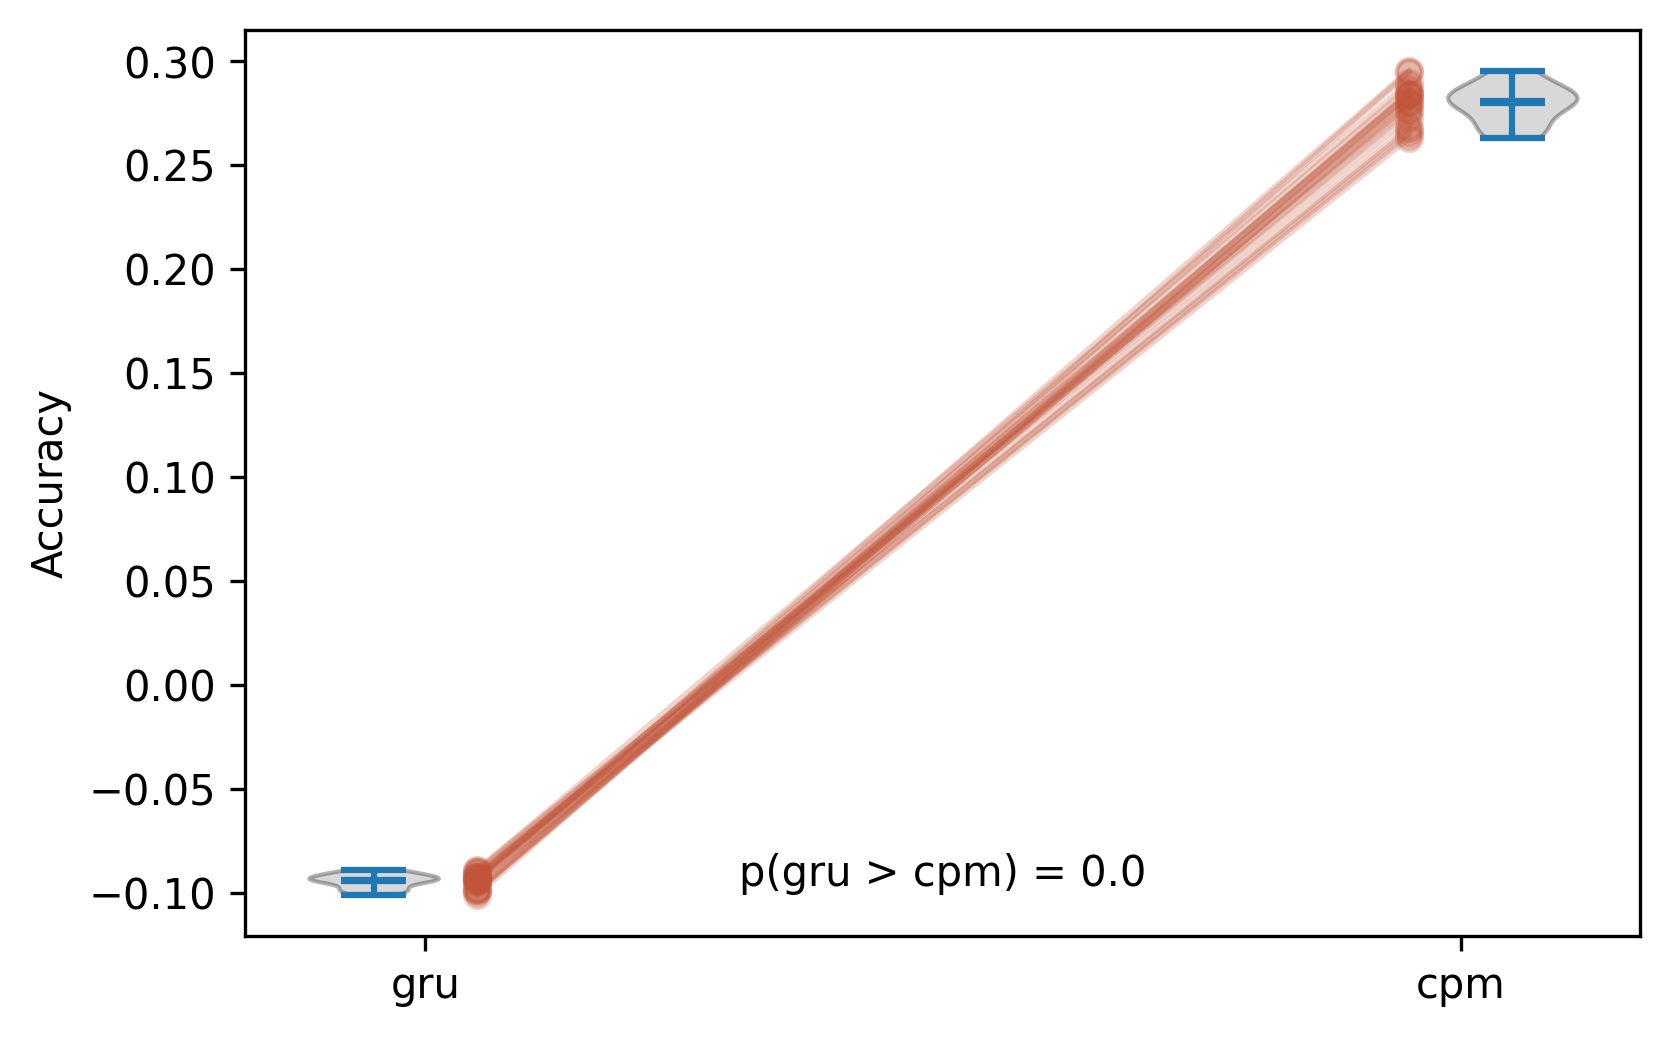


NEOFAC_N


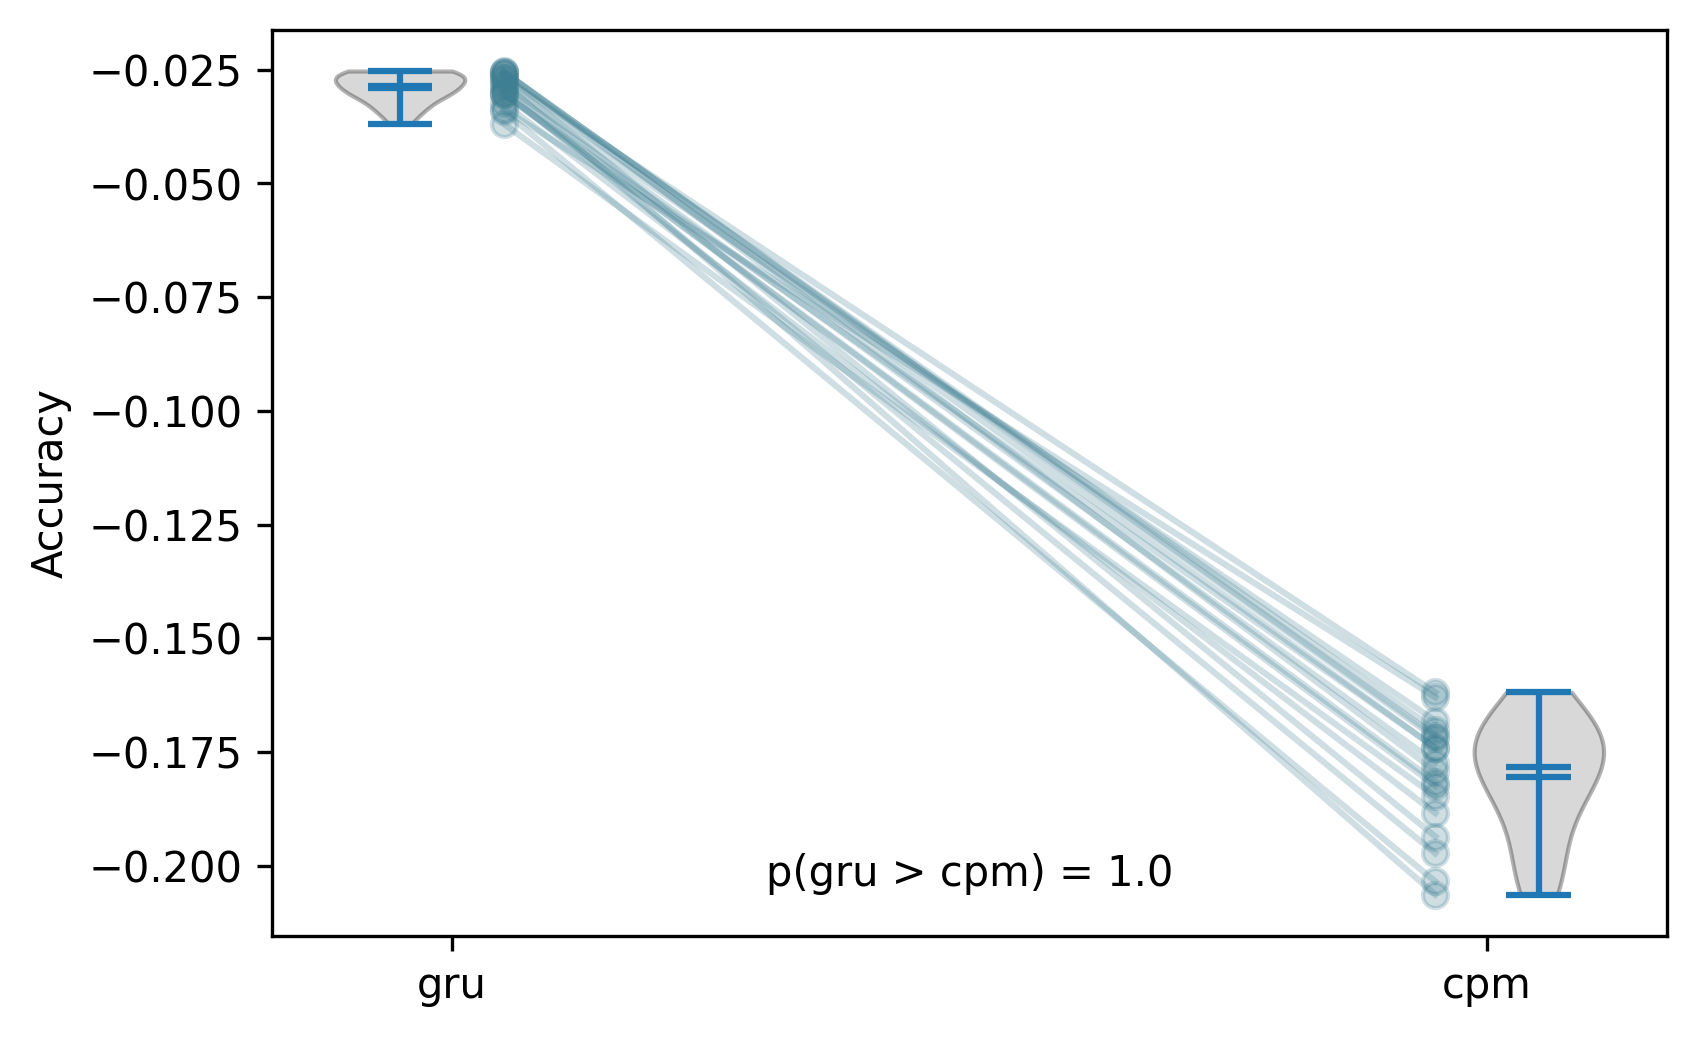


NEOFAC_O


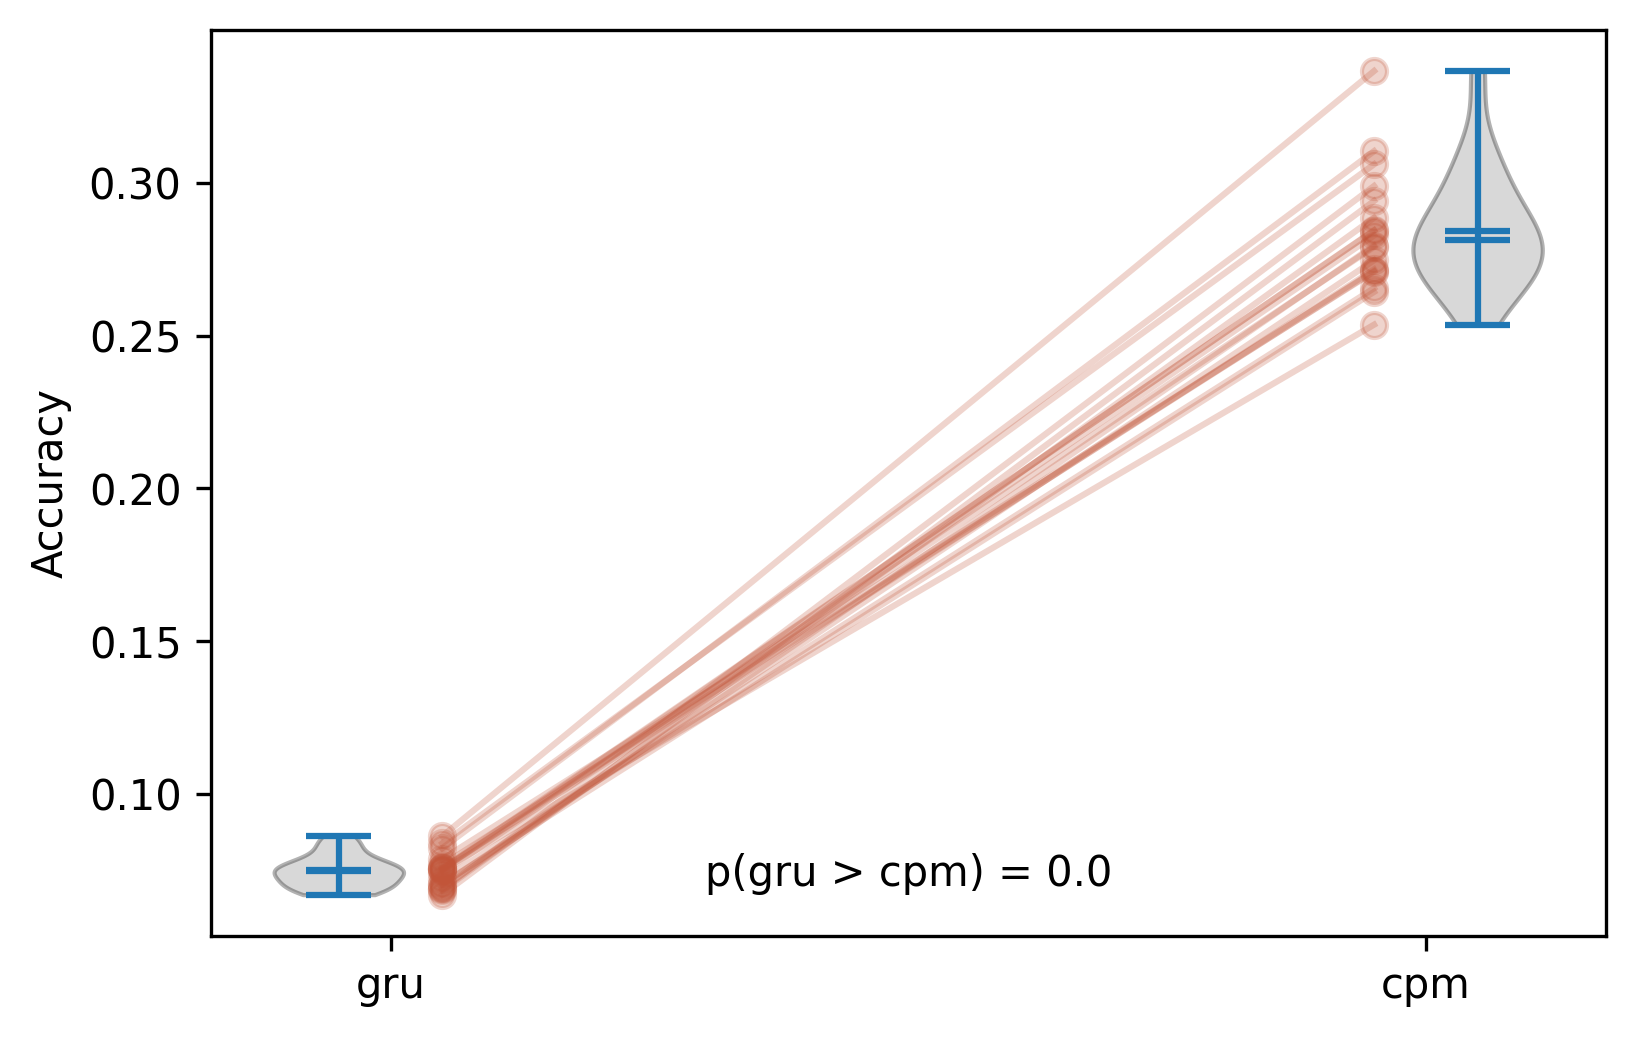

In [41]:
s = defaultdict(dict)

for kk in range(7):
    
    bhv = list(pretty_bhv.keys())[kk]
    print(pretty_bhv[bhv])
    
    r_gru = _get_results(args['gru'], 
                         bhv=bhv,
                         num_epochs=opt_hyperparam['gru'][bhv]['num_epochs'],
                         k_param=opt_hyperparam['gru'][bhv]['k_hidden'])

    k_param = opt_hyperparam['cpm'][bhv][args['cpm'].param_str]

    r_cpm = _get_results(args['cpm'],
                         bhv=bhv,
                         k_param=k_param)

    np.testing.assert_almost_equal(r_cpm['test_mode']['y'], r_gru['test_mode']['y'][:,0])

    s[pretty_bhv[bhv]] = {'gru':np.zeros((18,)),'cpm':np.zeros((18,))}

    # GRU
    for ii in range(18):
        mask = r_gru['test_mode']['y'][ii:ii+76,:] != 0
        y_hat = r_gru['test_mode']['y'][ii:ii+76,:][mask]
        y = r_gru['test_mode']['y_hat'][ii:ii+76,:][mask]
        s[pretty_bhv[bhv]]['gru'][ii] = spearmanr(y_hat,y)[0]

    # CPM
    for ii in range(18):
        y_hat = r_cpm['test_mode']['y'][ii:ii+76]
        y = r_cpm['test_mode']['y_hat'][ii:ii+76]
        s[pretty_bhv[bhv]]['cpm'][ii] = spearmanr(y_hat,y)[0]

    violin_slope_chart([s[pretty_bhv[bhv]]['gru'],'gru'],[s[pretty_bhv[bhv]]['cpm'],'cpm'])